# **Math-485: Topics in Data Science**

## **Textual Data Unit Project**

### Josh Winnes
---
## **Objective**

To produce an experimental evaluation of classifier performance on UN SDG labeled textual data. The evaluation should be conducted on a set of algorithms in combination with a set of NLP preprocessing steps, and conclude with the best performing algorithm with the associated preprocessing steps.

## **Specifications**

* prepare data as having been done in class and homework  
* write a function that will   
  * takes in a corpus (such as prepared so far) as input, and  
  * takes another parameter of “classifier\_algorithm” for the algorithm to use, the parameter settings for the algorithm should be part of the “classifier\_algorithm” parameter  
  * run the classifier with train\_test split, i.e., train on the training set and test on the test set  
  * report the metrics of precision, recall, f1\_score, and accuracy  
* run various classification algorithms on the UN SDG labeled data we have been using in class  
  * multinomial naive bayes   
  * multilayer perceptron (sklearn.neural\_network.MLPClassifier, note to use min\_df to ensure computation can be completed in reasonable time)  
  * ridge regression (sklearn.linear\_model.Ridge)  
  * combine with different preprocessing settings  
    * use count vectors vs. tfidf vectors  
    * use unigram only, bigram only, or both  
* evaluate all performance results in one table, with all configurations, bold face the numbers that give the best performance

for example, for one configuration, e.g., bigram with min\_df \= 3, the portion of table should contain

|  | MultinomialNB | MLP | Ridge |
| :---- | :---- | :---- | :---- |
| precision |  |  |  |
| recall |  |  |  |
| f1 |  |  |  |
| accuracy |  |  |  |

* for each SDG, what are the most differentiating features according to the classifier?  
* are there any overlaps between the SDG vocabularies?

## **Deliverables**

* A self contained python jupyter notebook that implements the specifications.  
* take the main text content from these pages, and feed them into your classifier and see how your model classifies them. Are the classifications reasonable? find a case where your classification is not reasonable and explain what the model does that leads to the not ideal classification.  
  [http://gianttortoise.org/en/beyond-tracking](http://gianttortoise.org/en/beyond-tracking)  
  [https://www.dhs.gov/blue-campaign/what-human-trafficking](https://www.dhs.gov/blue-campaign/what-human-trafficking)  
  [https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers](https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers)  
  [https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/](https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/)

## **Important note (to help reduce computation time if that is an issue)**

* when the classification takes too long to run on your computer (most likely they will on this project), set min\_df in the vectorizer to reduce the vocabulary size, which will reduce the matrix size drastically.   
* if you choose to run experiments on fewer number of SDGs, please be sure to include SDG 8 in your collection, and choose several others among  \[2,3,4,8,9,10,14,15,16\], to show your work on multiple classes

---

### **Scraping the Websites using Beautiful Soup 4**
This is necessary in order to get the text data into a dataframe so we can actually process the text in the website using our sklearn models later

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# List of URLs to scrape
urls = [
    "http://gianttortoise.org/en/beyond-tracking",
    "https://www.dhs.gov/blue-campaign/what-human-trafficking",
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers",
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/"
]

# Dictionary that links URLs to HTML Class names to locate the main text
class_name_dict = {
    "http://gianttortoise.org/en/beyond-tracking":'elementor-container elementor-column-gap-default',
    "https://www.dhs.gov/blue-campaign/what-human-trafficking":'field field--name-body field--type-text-with-summary field--label-hidden field__item',
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers":'field field--name-field-p-text field--type-text-long field--label-hidden clearfix',
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/":'post'
}

# Function to extract the main text from a webpage
def extract_main_text(url, class_name):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")

    # Extract main text        
    divs = soup.find_all('div', class_ = class_name)
    text = ''
    for div in divs:
        p_elements = div.find_all('p')
        li_elements = div.find_all('li')
        for p in p_elements:
            text += p.get_text() + " "
        for li in li_elements:
            text += li.get_text() + ' '

    return text

data = {"url": [], "text": []}

for url in urls:
    text = extract_main_text(url, class_name_dict.get(url))
    data["url"].append(url)
    data["text"].append(text)

# Create a DataFrame
df = pd.DataFrame(data)

df.head()

,url,text
0,http://gianttortoise.org/en/beyond-tracking,Having discovered some of the mechanisms gover...
1,https://www.dhs.gov/blue-campaign/what-human-t...,"Human trafficking involves the use of force, f..."
2,https://www.dol.gov/agencies/odep/program-area...,"Today, a confluence of factors is prompting Am..."
3,https://michigantoday.umich.edu/2022/08/26/pos...,"Scientist/author Becca Levy, BA ’87, is a prof..."


### **Importing the training data**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

In [4]:
data_dir = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True,drop=True)

In [5]:
corpus = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(corpus)
count_vector = count_vectorizer.transform(corpus).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
term_freq.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,8493
women,women,6017
development,development,5889
public,public,4819
social,social,4755
...,...,...
paik,paik,1
paiis,paiis,1
paie,paie,1
escarpment,escarpment,1


In [6]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_count_vector = count_vectorizer.transform(X_train) 
X_test_count_vector = count_vectorizer.transform(X_test) 

In [7]:
corpus = text_df.text
tfid_vectorizer = TfidfVectorizer(stop_words='english')
tfid_vectorizer.fit(corpus)
tfid_vector = tfid_vectorizer.transform(corpus).toarray() 
tfid_vector_df = pd.DataFrame(tfid_vector, columns=tfid_vectorizer.get_feature_names_out())
term_freq_tfid = pd.DataFrame({"term": tfid_vector_df.columns.values, "freq" : tfid_vector_df.sum(axis=0)})
term_freq_tfid.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,463.284281
women,women,417.534654
water,water,357.622939
development,development,354.622130
health,health,336.864059
...,...,...
emanuele,emanuele,0.082056
weimann,weimann,0.082056
gabriel,gabriel,0.082056
timcs,timcs,0.067789


In [8]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_tfid_vector = tfid_vectorizer.transform(X_train) 
X_test_tfid_vector = tfid_vectorizer.transform(X_test) 

### **Training the Models**

### Multinomial Naive Bayes

#### *Count Vector*

In [ ]:
count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred_mnb = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_mnb, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_mnb, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mnb))
print('Precision: ', metrics.precision_score(y_test, y_pred_mnb, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mnb, average='weighted'))

#### *TFID Vector*

In [ ]:
tfid_multinomialNB_clf = MultinomialNB().fit(X_train_tfid_vector, y_train)
y_pred_mnb_tfid = tfid_multinomialNB_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_mnb_tfid, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_mnb_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mnb_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_mnb_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mnb_tfid, average='weighted'))

### Multilayer Perceptron

#### *Count Vector*

In [ ]:
count_MLP_clf = MLPClassifier().fit(X_train_count_vector, y_train)
y_pred_mlp = count_MLP_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_mlp, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_mlp, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mlp))
print('Precision: ', metrics.precision_score(y_test, y_pred_mlp, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mlp, average='weighted'))

#### *TFID Vector*

In [ ]:
tfid_MLP_clf = MLPClassifier().fit(X_train_tfid_vector, y_train)
y_pred_mlp_tfid = tfid_MLP_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_mlp_tfid, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_mlp_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mlp_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_mlp_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mlp_tfid, average='weighted'))

### Ridge Classifier

#### *Count Vector*

In [ ]:
from sklearn.linear_model import RidgeClassifierCV

In [ ]:
count_ridge_clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='accuracy').fit(X_train_count_vector, y_train)
y_pred_ridge = count_ridge_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_ridge, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_ridge, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_ridge))
print('Precision: ', metrics.precision_score(y_test, y_pred_ridge, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_ridge, average='weighted'))

#### *TFID Vector*

In [ ]:
tfid_ridge_clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='accuracy').fit(X_train_tfid_vector, y_train)
y_pred_ridge_tfid = count_ridge_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test,y_pred_ridge_tfid, digits = 4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_ridge_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_ridge_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_ridge_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_ridge_tfid, average='weighted'))

### Random Forest

#### *Count Vector*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
count_rf_clf = RandomForestClassifier(max_depth=100).fit(X_train_count_vector, y_train)
y_pred_rf = count_rf_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test, y_pred_rf, digits=4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_rf, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_rf))
print('Precision: ', metrics.precision_score(y_test, y_pred_rf, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_rf, average='weighted'))

#### *TFID Vector*

In [ ]:
tfid_rf_clf = RandomForestClassifier(max_depth=100).fit(X_train_tfid_vector, y_train)
y_pred_rf_tfid = count_rf_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [ ]:
print(metrics.classification_report(y_test, y_pred_rf_tfid, digits=4))

In [ ]:
print('F1: ', metrics.f1_score(y_test, y_pred_rf_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_rf_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_rf_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_rf_tfid, average='weighted'))

### **Results**


#### *Count Vectorizer Classification*
|  | Multinomial NB | Multilayer Perceptron | Ridge | Random Forest |
| :---- | :---- | :---- | :---- | :---- |
| F1 | 0.838 | **0.876** | 0.871 | 0.825 |
| Accuracy | 0.844 | **0.876** | 0.873 | 0.832 |
| Precision | 0.848 | **0.876** | 0.872 | 0.829 |
| Recall | 0.844 | **0.876** | 0.873 | 0.832 |
#### *TF-IDF Vectorizer Classification*
|  | Multinomial NB | Multilayer Perceptron | Ridge | Random Forest |
| :---- | :---- | :---- | :---- | :---- |
| F1 | 0.689 | **0.883** | 0.608 | 0.078 |
| Accuracy | 0.719 | **0.884** | 0.612 | 0.107 |
| Precision | 0.799 | **0.883** | 0.811 | 0.752 |
| Recall | 0.719 | **0.883** | 0.612 | 0.107 |


In both cases, the Multilayer Perceptron classifier had the best score. The TF-IDF Vectorized Multilayer Perceptron Classifier had the highest accuracy score with 0.884, so I will use that model to classify the websites.

### **Classifying the Websites**

The Multilayer Perceptron Neural Network Classifier had the best accuracy score (0.87) so I will use it to classify the webpages.

In [ ]:
COUNT_CLASSIFIER = tfid_MLP_clf

text_to_predict = df.text
text_to_predict_transformed = count_vectorizer.transform(text_to_predict)

print('Count MLP Classifier Predicitions: ', COUNT_CLASSIFIER.predict(text_to_predict_transformed))


#### *Results Table*

| URL | SDG |
| ----- | ----- |
| https://gianttortoise.org/en/beyond-tracking | 15 \- Life on Land |
| https://www.dhs.gov/blue-campaign/what-human-trafficking | 5 \- Gender Equality |
| https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers | 4 \- Quality Education |
| https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/ | 3 \- Good Health and Well Being |

### **Testing out GloVe**

In [9]:
# Path to the chosen GloVe file (e.g., 100-dimensional embeddings)
glove_file = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/life things/data science/models/GloVe/glove.6B/glove.6B.100d.txt"

# Load the embeddings into a dictionary
embeddings_index = {}
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(corpus)

# Pad sequences to ensure uniform length
max_length = 10  # Set desired max length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print(f"Padded sequences:\n{padded_sequences}")

Vocabulary size: 53975
Padded sequences:
[[   25    93    11 ...    16   864    89]
 [   91     1   667 ...    23 11569    67]
 [    1   850     2 ...  2598   590  2552]
 ...
 [   89  2021    70 ...   156 53974   204]
 [ 1919     3   186 ...     6  2049   379]
 [    1   409     2 ...  1324     4   358]]


In [11]:
embedding_dim = 100  # Match the dimension of the GloVe vectors

# Initialize embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (53976, 100)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten

# Define the model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),  # Freeze the embeddings
    LSTM(128, return_sequences=False),  # Use LSTM for sequential data
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,397,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,397,600 (20.59 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,397,600 (20.59 MB)

In [16]:
# Train the model
model.fit(padded_sequences, text_df.sdg, epochs=10, batch_size=32)

Epoch 1/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0535 - loss: -4552.2251
Epoch 2/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0536 - loss: -59473.1875
Epoch 3/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0530 - loss: -175006.7031
Epoch 4/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0571 - loss: -338629.1562
Epoch 5/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0527 - loss: -546262.8125
Epoch 6/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0568 - loss: -783133.6250
Epoch 7/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0551 - loss: -1073969.2500
Epoch 8/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0575 - loss: -1368344.0000
Epoch 9/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0573 - loss: -1712902.3750
Epoch 10/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0559 - loss: -2091616.7500


trying again

In [32]:
import tensorflow as tf

# Define the model architecture again
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index), embedding_dim),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(text_df.sdg.unique()), activation='softmax')
])

In [33]:
model.compile(
    optimizer='adam',                   # Optimizer used for training
    loss='categorical_crossentropy',    # Loss function for multi-class classification
    metrics=['accuracy']                # Evaluation metric to track performance during training
)

In [37]:
from tensorflow.keras.utils import to_categorical

model.fit(padded_sequences, text_df.sdg, epochs=10, batch_size=32)

Epoch 1/10


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [39]:
text_df

,text_id,text,sdg,labels_negative,labels_positive,agreement,lang
0,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,8,0.777778,en
1,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,8,0.777778,en
2,000b54717f2deea5d99055b4c1c2bf5a,These findings are consistent with previous wo...,10,2,7,0.555556,en
3,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000,en
4,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000,en
...,...,...,...,...,...,...,...
26466,ffeb4e2b3d0f4d449053b1b15f51e4eb,"In Mauritius, housing development for the econ...",11,1,10,0.818182,en
26467,ffef3ec4ea192cdfed2ca43d4b2208a9,"In consequence, the number of urban dwellers p...",3,0,11,1.000000,en
26468,fff9b6b75bde5397ba26ed1b163ad306,"It also features individual accountability, wh...",4,0,9,1.000000,en
26469,fffe58dae29de6b843aff09b6e2f77f0,Groundwater quality can also be affected by co...,6,0,3,1.000000,en


trying again from the beginning

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



# Sample data preparation
# Assuming `df` is your DataFrame with 'text' and 'sdg' columns
texts = text_df['text'].values  # Your text data
labels = text_df['sdg'].values  # Your SDG labels

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)  # Number of unique labels

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

# Tokenize text
max_words = 10000  # The number of unique words to consider
max_length = 100  # Maximum length of sequences

# Tokenize the training and testing data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform input size
X_train_padded = pad_sequences(train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length)

# Encode the labels for training and testing sets
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

In [45]:
import tensorflow as tf

# Load pre-trained GloVe embeddings (e.g., 100-dimensional)
embedding_dim = 100
embedding_path = glove_file  # Adjust this path to your GloVe file location

# Load GloVe embeddings into a dictionary
embedding_index = {}
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix for the words in the tokenizer
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i > max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False  # Set to True if you want to fine-tune the embeddings
)

/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Flatten(),  # You can use other layers like LSTM or GRU for sequential data
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # For multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     4,801,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801,400 (18.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,801,400 (18.32 MB)

In [47]:
# Train the model
history = model.fit(padded_sequences, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
659/662 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1082 - loss: 2.7944

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 5295
'y' sizes: 0


starting over from the beginning, making progress

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [49]:
# Sample data preparation
texts = text_df['text'].values  # Your text data
labels = text_df['sdg'].values  # Your SDG labels

In [50]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [51]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

In [52]:
max_words = 10000  # Number of unique words to consider
max_length = 100  # Maximum length of sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform input size
X_train_padded = pad_sequences(train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [53]:
embedding_dim = 100  # Adjust this as needed
embedding_path = glove_file  # Adjust this path to your GloVe file location

# Load GloVe embeddings into a dictionary
embedding_index = {}
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix for the words in the tokenizer
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i > max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False  # Set to True if you want to fine-tune the embeddings
)

/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Flatten(),  # You can use LSTM or GRU for sequential data
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # For multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     4,801,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801,400 (18.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,801,400 (18.32 MB)

In [55]:
# Train the model
history = model.fit(X_train_padded, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3901 - loss: 1.9727 - val_accuracy: 0.5831 - val_loss: 1.3079
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7903 - loss: 0.7054 - val_accuracy: 0.6369 - val_loss: 1.1741
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9277 - loss: 0.3082 - val_accuracy: 0.6176 - val_loss: 1.3145
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9793 - loss: 0.1300 - val_accuracy: 0.6367 - val_loss: 1.3973
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9968 - loss: 0.0505 - val_accuracy: 0.6261 - val_loss: 1.4666
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.6357 - val_loss: 1.4952
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.6369 - val_loss: 1.5440
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.

In [56]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test_padded, y_test_one_hot)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 1.6623
Test Loss: 1.6926798820495605, Test Accuracy: 0.6502360701560974


In [57]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_padded)

# Convert the probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [58]:
# Convert the one-hot encoded true labels to class labels
y_true = np.argmax(y_test_one_hot, axis=1)

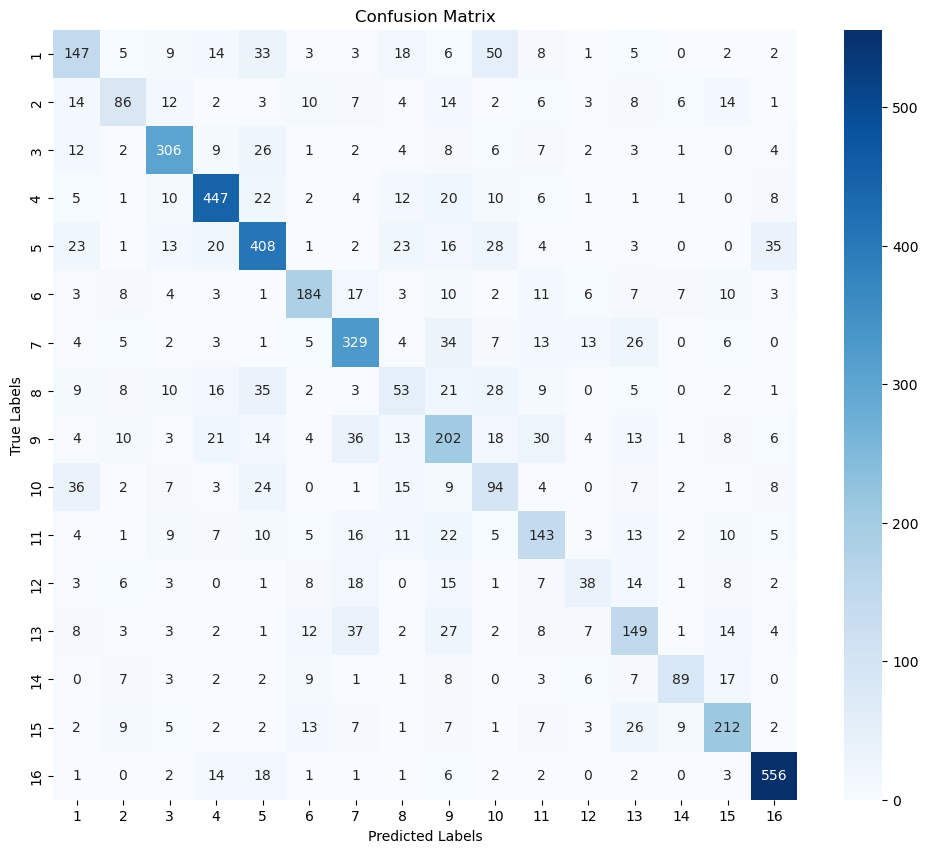

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [60]:
df

,url,text
0,http://gianttortoise.org/en/beyond-tracking,Having discovered some of the mechanisms gover...
1,https://www.dhs.gov/blue-campaign/what-human-t...,"Human trafficking involves the use of force, f..."
2,https://www.dol.gov/agencies/odep/program-area...,"Today, a confluence of factors is prompting Am..."
3,https://michigantoday.umich.edu/2022/08/26/pos...,"Scientist/author Becca Levy, BA ’87, is a prof..."


In [61]:
# List of new texts to classify
new_texts = df.text

In [62]:
# Tokenize the new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)

# Pad the sequences
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length)

In [63]:
# Make predictions
predictions_prob = model.predict(new_padded_sequences)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions_prob, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [64]:
# Convert numeric labels to their corresponding SDG names
predicted_sdg_labels = label_encoder.inverse_transform(predicted_labels)

# Display the predictions
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print(f"Predicted SDG: {predicted_sdg_labels[i]}\n")

Text: Having discovered some of the mechanisms governing migration and other movements, we wanted to place our new knowledge into a wider ecological and conservation context. We knew that food availability influenced tortoise migrations, but we had little data on tortoise diets. Previous studies had been conducted in the 1980s before the explosion of introduced species on Santa Cruz Island. We spent several hundred hours observing tortoises and recording all feeding activity, noting the plant species eaten and other details such as bites per minute. We also studied how plant communities change along the elevation gradient. Tortoises eat at least 96 different plant species. Young mature leaves are preferred, and fruit also makes up a large part of the diet. Galapagos tortoises consume many plant species that were introduced to Galapagos by people often preferring these over native and endemic plant species. Many of these species were brought to Galapagos as food sources for people and l